# FlexiFlow Lifetime-Aware Modeling

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
import pandas as pd

from lifetime_modeling import *

In [2]:
load_execution_time_from_csv("timing.csv")
load_embodied_values_from_csv("embodied-carbon.csv")
load_memory_from_csv("memory.csv")


## Lifetime Modeling

In [ ]:
# -----------------------------------------
# 2) Set up interactive widgets
# -----------------------------------------
workload_dropdown = widgets.Dropdown(
    options=execution_time.keys(),
    value="Food Spoilage Detection",
    description="Workload:",
)

lifetime_slider = widgets.FloatSlider(
    value=1.0,
    min=MIN_LIFETIME,
    max=MAX_LIFETIME,
    step=0.5,
    description='Lifetime (yrs)'
)

inf_freq_slider = widgets.BoundedFloatText(
    value=1.0,
    min=MIN_INF_FREQ,
    max=MAX_INF_FREQ,
    step=1.0,
    description='Number of Executed Tasks per Year'
)

power_source_dropdown = widgets.Dropdown(
    options=carbon_intensity_values.keys(),
    value=list(carbon_intensity_values.keys())[0],
    description="Power Source:",
)

carbon_intensity_box = widgets.Text(
    value=carbon_intensity_values[power_source_dropdown.value],
    description="Carbon Int. (CO₂/unit energy)",
)

carbon_intensity_box.disabled = True
def update_carbon_intensity(*args):
    if power_source_dropdown.value == "Custom":
        carbon_intensity_box.disabled = False
    else:
        carbon_intensity_box.value = carbon_intensity_values[power_source_dropdown.value]
        carbon_intensity_box.disabled = True

power_source_dropdown.observe(update_carbon_intensity, 'value')

core_freq_box = widgets.BoundedFloatText(
    value=10000.0,
    min=1000.0,
    max=100000.0,
    step=100.0,
    description='Core Freq'
)

ui = widgets.VBox([
    workload_dropdown,
    lifetime_slider,
    inf_freq_slider,
    power_source_dropdown,
    carbon_intensity_box,
    core_freq_box
])

out = widgets.interactive_output(
    plot_carbon_vs_lifetime,
    {
        'workload_choice': workload_dropdown,
        'lifetime_yrs': lifetime_slider,
        'inf_freq': inf_freq_slider,
        'carbon_intensity': carbon_intensity_box,
        'core_freq': core_freq_box,
    }
)

display(ui, out)

Output()

## Additional Analysis

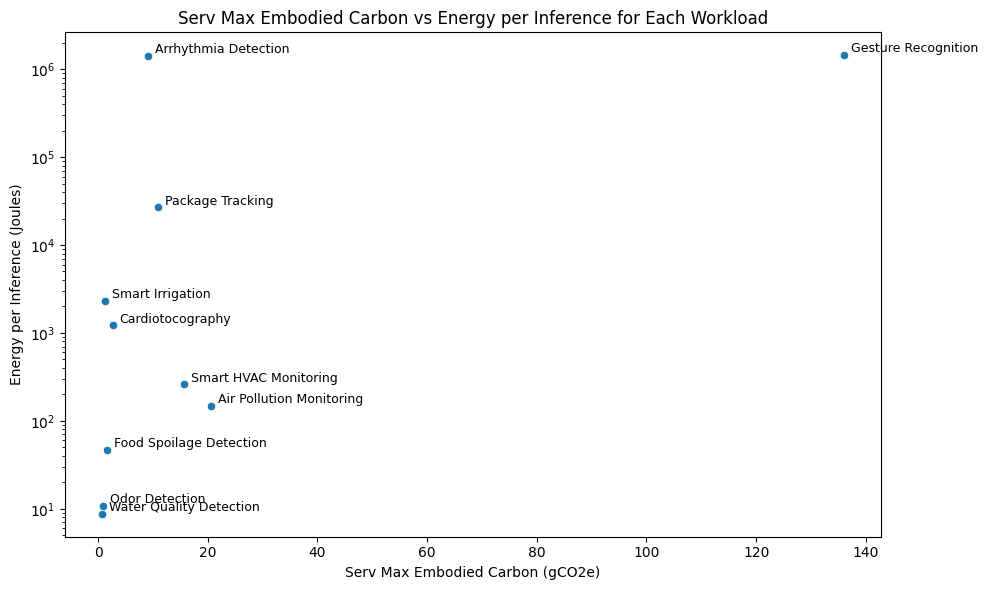

In [4]:
def plot_serv_embodied_vs_energy_per_inference():
    workloads = list(sram.keys())
    data = []

    for workload in workloads:
        # Get Serv max embodied carbon
        try:
            embodied = embodied_values[workload]["Serv"]["Carbon Footprint Max (gCO2e)"]
        except KeyError:
            continue  # skip if not available

        # Get energy per inference for Serv
        # Use default core_freq = 10000 (arbitrary, since energy per inference is independent of frequency)
        system = "Serv"
        core_freq = 10000  # Hz, but cancels out
        sram_bytes = sram[workload] + rf_sram
        lprom_bytes = lprom[workload]
        system_power = system_specs[system]["power"]
        total_power = system_power + (sram_power + sram_overhead_power) * sram_bytes * 8 + lprom_power * lprom_bytes * 8
        time_per_inference = execution_time[workload][system] / core_freq
        energy_per_inference = total_power * time_per_inference  # in Joules

        data.append({
            "Workload": workload,
            "Embodied": embodied,
            "EnergyPerInference": energy_per_inference
        })

    df = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x="Embodied",
        y="EnergyPerInference",
        ax=ax
    )

    for i, row in df.iterrows():
        ax.annotate(row["Workload"], (row["Embodied"], row["EnergyPerInference"]), fontsize=9, xytext=(5,2), textcoords='offset points')

    ax.set_xlabel("Serv Max Embodied Carbon (gCO2e)")
    ax.set_ylabel("Energy per Inference (Joules)")
    ax.set_yscale('log')
    ax.set_title("Serv Max Embodied Carbon vs Energy per Inference for Each Workload")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_serv_embodied_vs_energy_per_inference()


/var/folders/bv/n2w_m8nj73g0p2j9wwv286yw0000gn/T/ipykernel_20235/1352331704.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


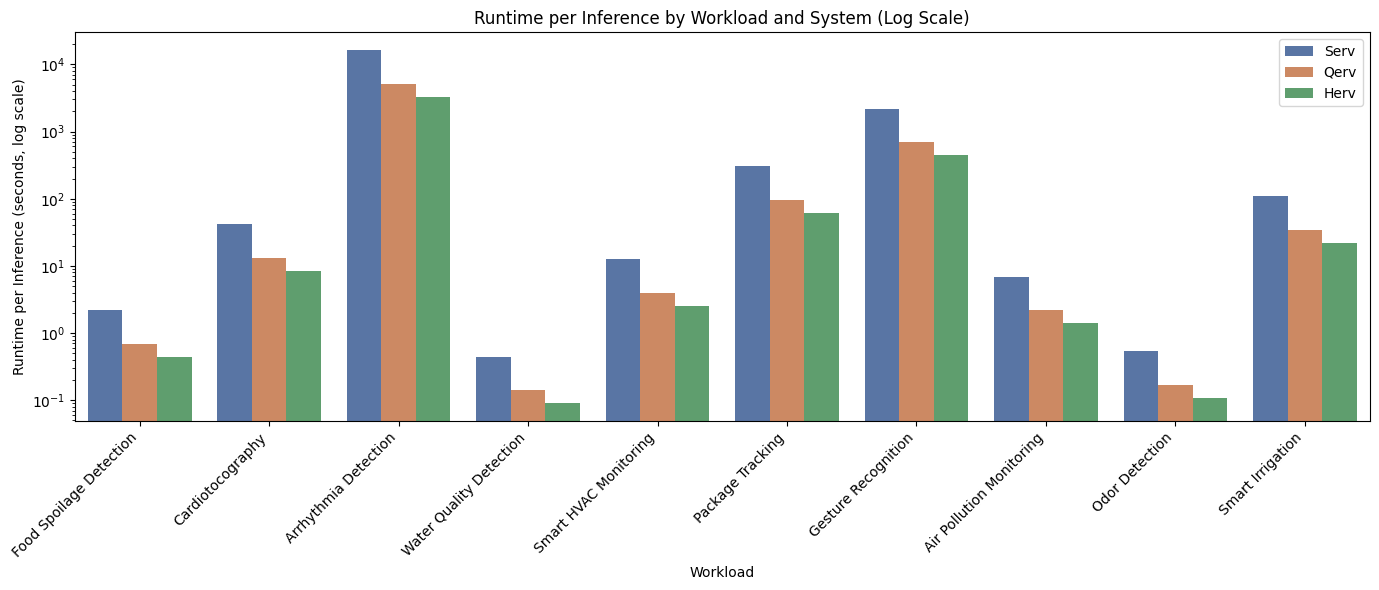

In [5]:
def plot_runtime_per_workload_log():
    workloads = list(execution_time.keys())
    systems = ["Serv", "Qerv", "Herv"]
    core_freq = 10000

    # Use system_colors for consistent coloring
    palette = [system_colors[sys] for sys in systems]

    data = []
    for workload in workloads:
        for system in systems:
            try:
                runtime = execution_time[workload][system] / core_freq
            except KeyError:
                runtime = np.nan
            data.append({
                "Workload": workload,
                "System": system,
                "Runtime": runtime
            })

    df = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=(14, 6))
    sns.barplot(
        data=df,
        x="Workload",
        y="Runtime",
        hue="System",
        ax=ax,
        palette=palette
    )

    ax.set_yscale('log')
    ax.set_ylabel('Runtime per Inference (seconds, log scale)')
    ax.set_title('Runtime per Inference by Workload and System (Log Scale)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_runtime_per_workload_log()
